# Tutorial: $\gamma$-$\gamma$ Absorption in the Photon Fields of Line and Thermal Emitters
In this tutorial we will illustrate how to use `agnpy` to compute the $\gamma$-$\gamma$ absorption due to the photon fields produced by the BLR and DT photon fields.

In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import M_sun
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

In [2]:
from agnpy.targets import SphericalShellBLR, RingDustTorus, PointSourceBehindJet
from agnpy.absorption import Absorption
from agnpy.utils.plot import load_mpl_rc

# matplotlib adjustments
load_mpl_rc()

## Absorption in the photon field of a spehrical shell BLR 
Let us consider a BLR composed of a single spherical shell emitting the Ly$\alpha$ line. Let us take, following Finke (2016) - [see bibliography in the docs](https://agnpy.readthedocs.io/en/latest/bibliography.html), the following parameters representing the blazar 3C 454.3: $L_{\rm disk} = 2 \times 10^{46}\,{\rm erg}\,{\rm s}^{-1}$, $\xi_{\rm li} = 0.1$, $R_{\rm Ly\alpha} = 1.1 \times 10^{17}\,{\rm cm}$.    The redshift of the source is $z = 0.859$.

In [3]:
L_disk = 2 * 1e46 * u.Unit("erg s-1")
xi_line = 0.1
R_line = 1.1 * 1e17 * u.cm
blr = SphericalShellBLR(L_disk, xi_line, "Lyalpha", R_line)

The `Absorption` class, in the case of a photon target, needs to be initialised: the target instance, the distance from the target $r$ and the redshift of the source (energies have to be converted to the galaxy frame). 
Let us actually compare the absorptions for two cases: inside ($r = 0.1 \times R_{\rm Ly\alpha}$) and outside ($r = 10 \times R_{\rm Ly\alpha}$) the BLR.

In [4]:
z = 0.859
r_in_blr = 0.1 * R_line
r_out_blr = 10 * R_line

# evaluate the two absorptions
abs_in_blr = Absorption(blr, r=r_in_blr, z=z)
abs_out_blr = Absorption(blr, r=r_out_blr, z=z)

Let us evaluate the absorption in the same energy range considered in Figure 14 of Finke 2016: $[1, 10^5]\,{\rm GeV}$

In [5]:
E = np.logspace(0, 5) * u.GeV
nu = E.to("Hz", equivalencies=u.spectral())
# evaluate the opacities
tau_in_blr = abs_in_blr.tau(nu)
tau_out_blr = abs_out_blr.tau(nu)

/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


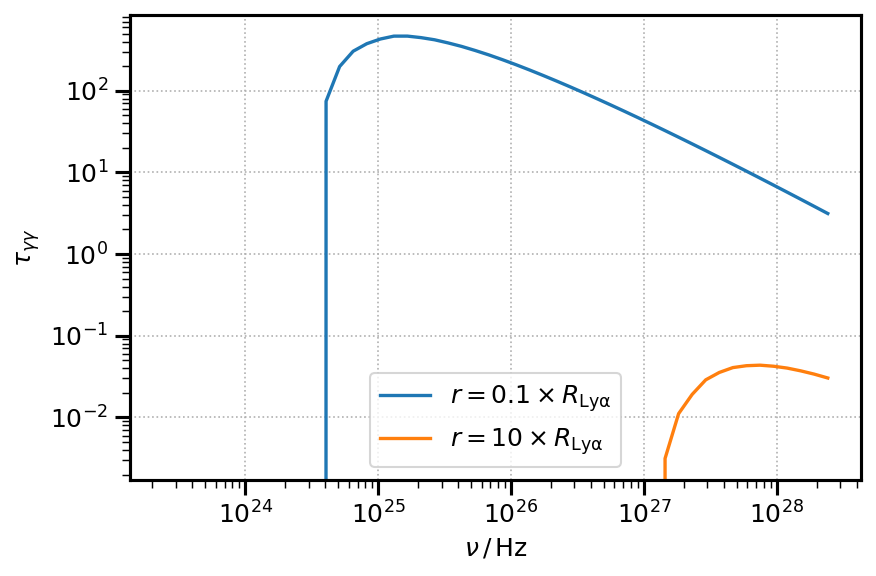

In [6]:
# let us plot them
plt.loglog(nu, tau_in_blr, label=r"$r = 0.1 \times R_{\rm Ly\alpha}$")
plt.loglog(nu, tau_out_blr, label=r"$r = 10 \times R_{\rm Ly\alpha}$")
plt.legend()
plt.ylabel(r"$\tau_{\gamma \gamma}$", fontsize=12)
plt.xlabel(r"$\nu\,/\,{\rm Hz}$", fontsize=12)
plt.show()

### Opacity of a misaligned (non-blazar) source
In the default opacity calculation, `agnpy` assumes the line of sight of the observer to be aligned with the jet (i.e. the source is a blazar with $\mu_s = 1$, where $\theta_s$ is the viewing angle and $\mu_s$ its cosine). This brings a considerable simplification in the opacity calculation (see the main documentation). 

For some sources `agnpy` allows the calculation of the opacity for an aribitrary viewing angle (this is possible for BLR, DT and point source behind the blob - as of version 0.0.10). Let us assume we are considering a source with the same parameters of 3C 454.3 in the previous example, but with a viewing angle of $20\,{\rm deg}$. Let us evaluate the absorption within the BLR for the aligned and misaligned case 

In [7]:
mu_s = np.cos(np.deg2rad(20))
abs_in_blr_mis = Absorption(blr, r=r_in_blr, z=z, mu_s=mu_s)
# evaluate the opacity
tau_in_blr_mis = abs_in_blr_mis.tau(nu)

/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


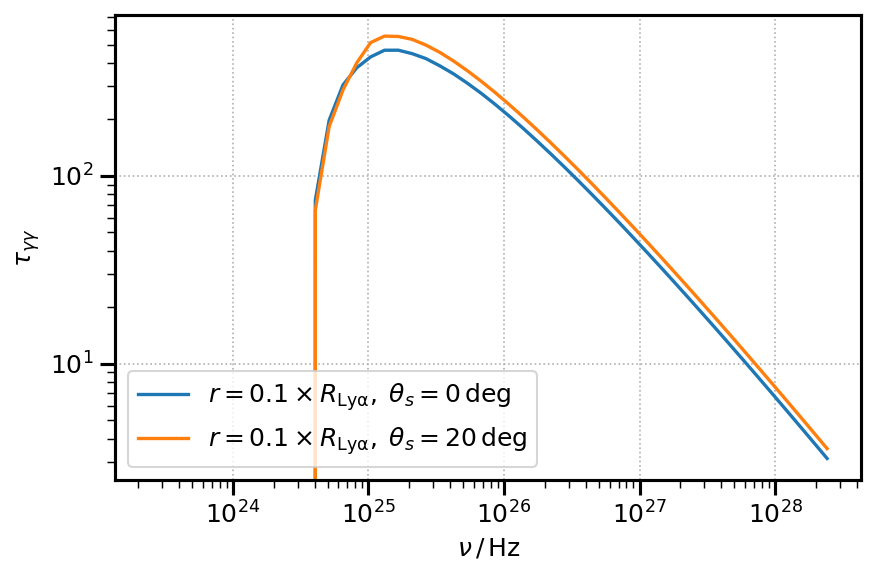

In [8]:
# compare the opacity in the aligned and misaligned case
plt.loglog(
    nu, tau_in_blr, label=r"$r = 0.1 \times R_{\rm Ly\alpha},\;\theta_s=0\,{\rm deg}$"
)
plt.loglog(
    nu,
    tau_in_blr_mis,
    label=r"$r = 0.1 \times R_{\rm Ly\alpha},\;\theta_s=20\,{\rm deg}$",
)
plt.legend()
plt.ylabel(r"$\tau_{\gamma \gamma}$", fontsize=12)
plt.xlabel(r"$\nu\,/\,{\rm Hz}$", fontsize=12)
plt.show()

### Comparison of the misaligned case with a point source behind the blob
The opacity for the misaligned case, in the limit of large distances $r >> R_{\rm Ly\alpha}$, should reduce to the same opacity produced by a monochromatic point source behind the jet approximating the BLR (in luminosity and emitted energy). 

**Note** this comparison is not possible for the aligned case since for $\mu_s=1$ there is no absorption from the target photons (factor $(1 - \mu_s)$ null in the opacity formula).

In [9]:
# point source with the same luminosity as the BLR
ps_blr = PointSourceBehindJet(blr.xi_line * L_disk, blr.epsilon_line)

# absorption in the limit of very large distances
r_far_blr = 1e2 * R_line
abs_far_blr_mis = Absorption(blr, r=r_far_blr, z=z, mu_s=mu_s)
abs_far_ps_blr_mis = Absorption(ps_blr, r=r_far_blr, z=z, mu_s=mu_s)

In [10]:
# compute the opacities
tau_far_blr_mis = abs_far_blr_mis.tau(nu)
tau_far_ps_blr_mis = abs_far_ps_blr_mis.tau(nu)

/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


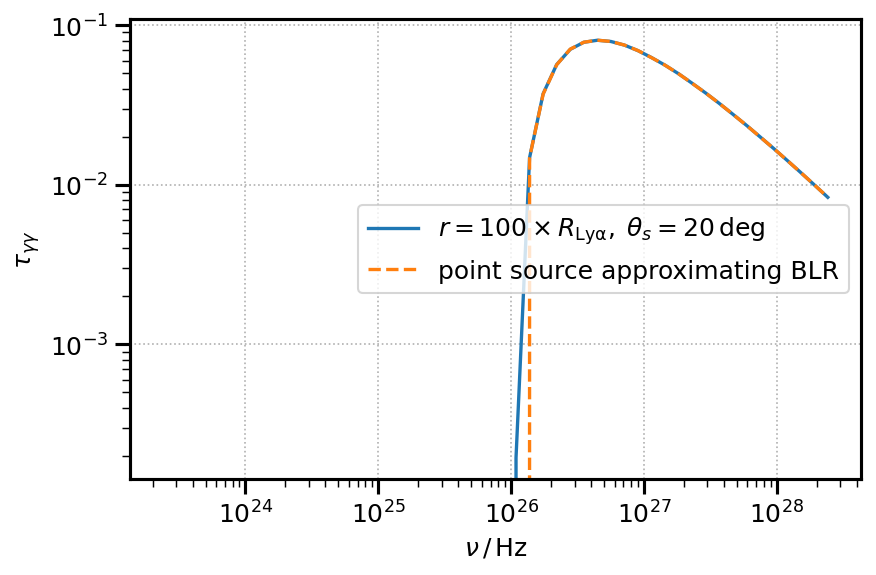

In [11]:
# compare the opacity in the aligned and misaligned case
plt.loglog(
    nu,
    tau_far_blr_mis,
    label=r"$r = 100 \times R_{\rm Ly\alpha},\;\theta_s=20\,{\rm deg}$",
)
plt.loglog(nu, tau_far_ps_blr_mis, ls="--", label="point source approximating BLR")
plt.legend()
plt.ylabel(r"$\tau_{\gamma \gamma}$", fontsize=12)
plt.xlabel(r"$\nu\,/\,{\rm Hz}$", fontsize=12)
plt.show()

## Absorption in the photon field of a ring dust torus 
Let us consider a ring dust torus. Following Finke (2016) - [see bibliography in the docs](https://agnpy.readthedocs.io/en/latest/bibliography.html), we adopt the following parameters: $L_{\rm disk} = 2 \times 10^{46}\,{\rm erg}\,{\rm s}^{-1}$, $\xi_{\rm li} = 0.2$, $T_{\rm dt} = 10^3\,{\rm K}$. The redshift of the source is $z = 0.859$.

In [12]:
dt = RingDustTorus(L_disk, 0.2, 1000 * u.K)
print(dt.R_dt)

1.565247584249853e+19 cm


Again, let us consider two cases of abosrption: inside ($r = 0.1 \times R_{\rm dt}$) and outside ($r = 2 \times R_{\rm dt}$) the torus

In [13]:
r_in_dt = 0.1 * dt.R_dt
r_out_dt = 2 * dt.R_dt

# define the absorption objects
abs_in_dt = Absorption(dt, r=r_in_dt, z=z)
abs_out_dt = Absorption(dt, r=r_out_dt, z=z)

# evaluate the opacities
tau_in_dt = abs_in_dt.tau(nu)
tau_out_dt = abs_out_dt.tau(nu)

/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


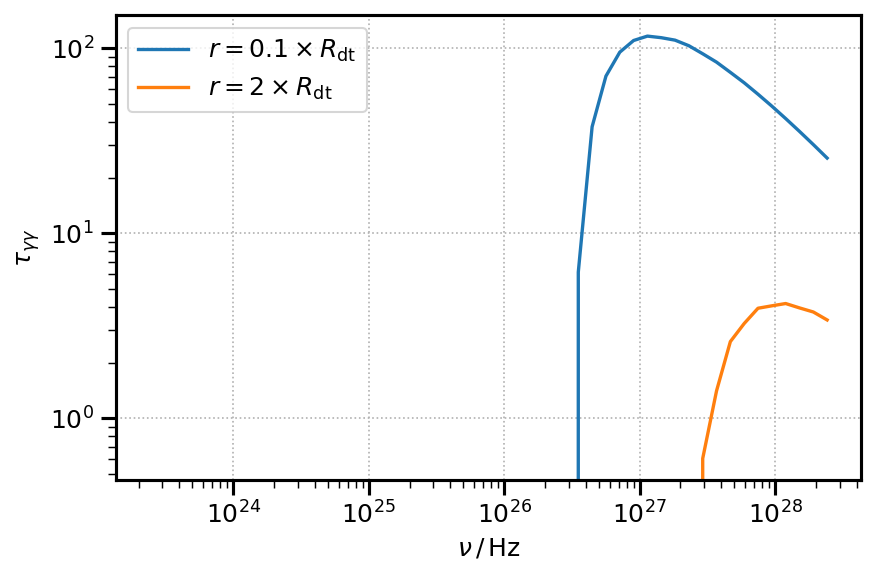

In [14]:
# let us plot them
plt.loglog(nu, tau_in_dt, label=r"$r = 0.1 \times R_{\rm dt}$")
plt.loglog(nu, tau_out_dt, label=r"$r = 2 \times R_{\rm dt}$")
plt.legend()
plt.ylabel(r"$\tau_{\gamma \gamma}$", fontsize=12)
plt.xlabel(r"$\nu\,/\,{\rm Hz}$", fontsize=12)
plt.show()

### Opacity of a misaligned (non-blazar) source
As already explained in the previous opacity calculation, `agnpy` will assume the line of sight of the observer to be aligned with the jet ($\mu_s = 1$). 
Let us perform a comparison with a source with the same dust torus defined above, but with a viewing angle of $20\,{\rm deg}$. Let us evaluate the absorption within the DT for the aligned and misaligned case 

In [15]:
mu_s = np.cos(np.deg2rad(20))
abs_in_dt_mis = Absorption(dt, r=r_in_dt, z=z, mu_s=mu_s)
# evaluate the opacity
tau_in_dt_mis = abs_in_blr_mis.tau(nu)

/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


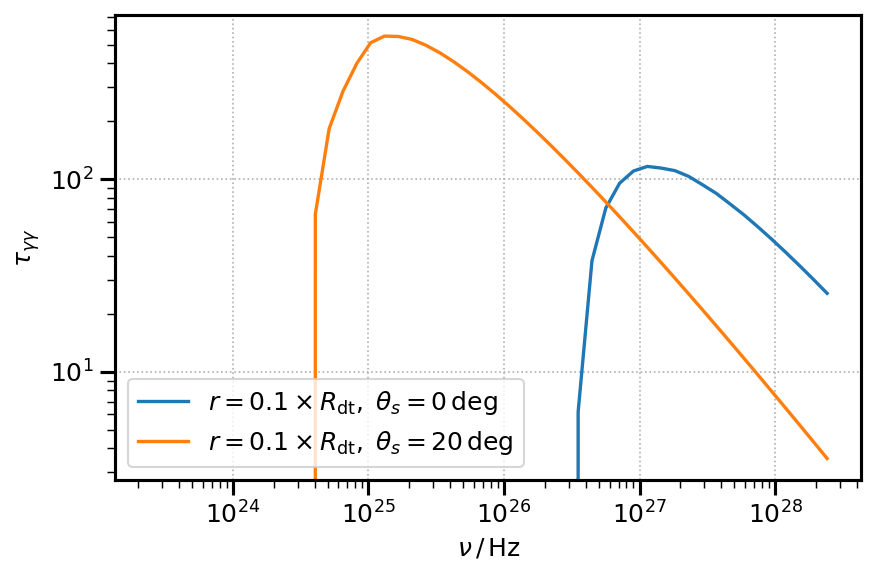

In [16]:
# compare the opacity in the aligned and misaligned case
plt.loglog(nu, tau_in_dt, label=r"$r = 0.1 \times R_{\rm dt},\;\theta_s=0\,{\rm deg}$")
plt.loglog(
    nu, tau_in_dt_mis, label=r"$r = 0.1 \times R_{\rm dt},\;\theta_s=20\,{\rm deg}$"
)
plt.legend()
plt.ylabel(r"$\tau_{\gamma \gamma}$", fontsize=12)
plt.xlabel(r"$\nu\,/\,{\rm Hz}$", fontsize=12)
plt.show()

### Comparison of the misaligned case with a point source behind the blob
And again, we can compare the opacity for the misaligned case, in the limit of large distances $r >> R_{\rm dt}$, with the opacity produced by a point source behind the jet approximating (in luminosity and emitted energy) the DT. 

In [17]:
# point source approximating the dust torus
ps_dt = PointSourceBehindJet(dt.xi_dt * L_disk, dt.epsilon_dt)

# absorption in the limit of very large distances
r_far_dt = 100 * dt.R_dt
abs_far_dt_mis = Absorption(dt, r=r_far_dt, z=z, mu_s=mu_s)
abs_far_ps_dt_mis = Absorption(ps_dt, r=r_far_dt, z=z, mu_s=mu_s)

In [18]:
# compute the opacities
tau_far_dt_mis = abs_far_dt_mis.tau(nu)
tau_far_ps_dt_mis = abs_far_ps_dt_mis.tau(nu)

/Users/cosimo/software/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


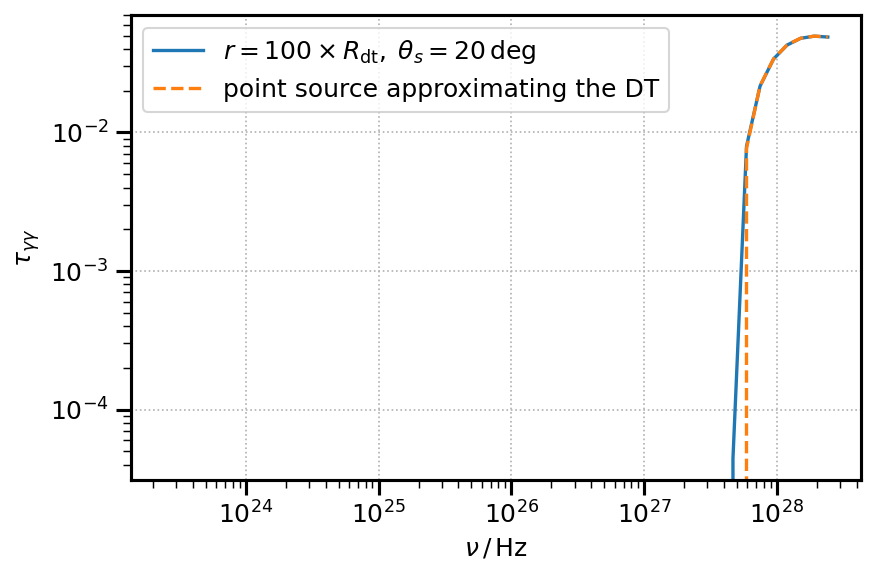

In [19]:
# compare the opacity in the aligned and misaligned case
plt.loglog(
    nu, tau_far_dt_mis, label=r"$r = 100 \times R_{\rm dt},\;\theta_s=20\,{\rm deg}$"
)
plt.loglog(nu, tau_far_ps_dt_mis, ls="--", label="point source approximating the DT")
plt.legend()
plt.ylabel(r"$\tau_{\gamma \gamma}$", fontsize=12)
plt.xlabel(r"$\nu\,/\,{\rm Hz}$", fontsize=12)
plt.show()